LAB2

1. Lag et mikrofonarray med geometri som i figur II.4. Velg d slik at alle mikrofonene får plass
på koblingsbrettet.

d = 6.5 midt til midt
d= = 5.5 kant til kant

2. Gjør et opptak av et lydsignal med de tre mikrofonene, og vis at de tre signalene ser ut som
forventet, dvs amplituden skal variere rundt 0∗
, og avhengig av hvilket signal du brukte skal
alle tre se ut som sinustoner, impulslyder, støysignaler, eller et slikt signal som du brukte.

importering av pakker som trengs

In [100]:
import numpy as np
import matplotlib.pyplot as plt
#from sympy import *
from raspi_import import raspi_import
import scipy.signal as sc

In [ ]:
#hente inn data fra måling
#1000Hz_sinus_180G.bin klapp_0G.bin

mode = "klapp"
for i in [0, 45, 90, 135, 180]:
    sample_period, data = raspi_import(mode+str(i)+"G.bin")

    #juster data
    k= 3.3/4096 #2^12 pga 12-bits ADC bit_signal = Signal/k
    data = data[5000:,:]*k 
    data = data - np.mean(data, axis=0) #fjerner DC-komponenten til signalet

    fs = 1/sample_period

    mic_1 = data[:,0] #ADC1
    mic_2 = data[:,3] #ADC4
    mic_3 = data[:,2] #ADC3

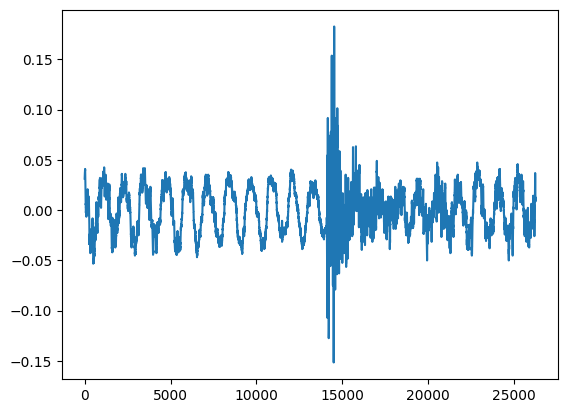

In [102]:
plt.plot(mic_1)
plt.show()

3. Implementer en krysskorrelasjonsberegning for de tre mikrofonsignalene. Finn tidsforsinkelsen
fra toppen av krysskorrelasjonen, uttrykkt i antall sampler og vis de tre krysskorrelasjonssignalene. Du må også vise et eksempel på et autokorrelasjonssignal. Sjekk at du får en topp for eksakt 0 sampels «lag». 
Er toppen for disse krysskorrelasjonssignalene innenfor et intervall som kan forventes, dvs
innenfor ±nmax, hvor nmax gis av avstand mellom mikrofonene, samplingfrekvensen og lydhastigheten?

Funksjon for auto og krysskorrelasjon

In [103]:
#Slower
#r_xy = np.correlate(x,y, mode='full')
#r_xy_abs = np.abs(r_xy)

In [104]:
#Faster
def krysskorrelasjon(x,y): #sett inn data fra ønskede mikrofoner
    r_xy = sc.correlate(x,y, mode='full')
    print(f"Krysskorrelasjonen har en spike ved {np.argmax(r_xy)}")
    return r_xy
def autokorrelasjon(x):
    r_xx = sc.correlate(x, x, mode='full')
    print(f"Autokorrelasjonen har en spike ved {np.argmax(r_xx)}")
    return r_xx


Kode for tidsforsinkelse (delay)

In [105]:
def delay(x, r_xy, micnr, another_micnr): #tar inn parametere x:ett av signalene, r_xy:krysskorrelsjonen
    r_xy_abs = np.abs(r_xy)
    l_max = np.argmax(r_xy_abs) - (len(x) - 1)
    delta_t = l_max/fs
    print(f"Delay mellom mikrofon mic {micnr} og mic {another_micnr} i sekunder: {delta_t} s")
    return delta_t #enhet sekunder

def delay_samples(x, y, micnr, another_micnr):
    n_samples = np.argmax(krysskorrelasjon(x,y)) - np.argmax(autokorrelasjon(x))
    print(f"Delay mellom mikrofon mic {micnr} og mic {another_micnr} i antall samples: {n_samples}")
    return n_samples #enhet antall samples

Plot av teori ang krysskorrelasjon

Krysskorrelasjonen har en spike ved 983


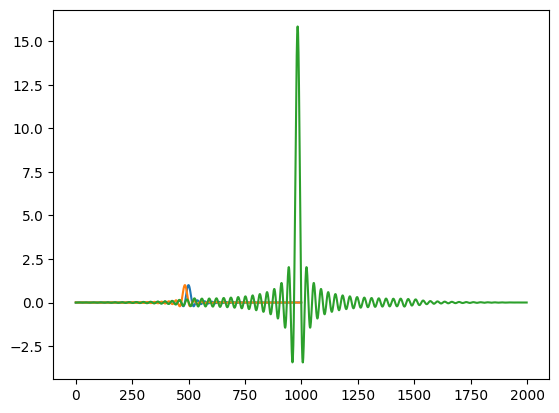

In [106]:
t = np.linspace(-5,5, 1000)*np.pi*2
r_11 = krysskorrelasjon(np.sinc(t+2),np.sinc(t+1))

plt.plot(np.sinc(t))
plt.plot(np.sinc(t+1))
plt.plot(r_11)
plt.show()

Utregning av krysskorrelasjon mellom dataen fra mikrofonene

In [107]:
r_21 = krysskorrelasjon(mic_2,mic_1)
r_31 = krysskorrelasjon(mic_3,mic_1)
r_32 = krysskorrelasjon(mic_3,mic_2)

Krysskorrelasjonen har en spike ved 26246
Krysskorrelasjonen har en spike ved 26246
Krysskorrelasjonen har en spike ved 26249


Plot av krysskorrelasjoner

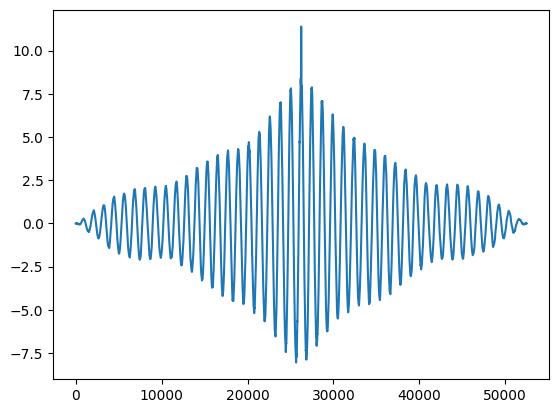

Delay mellom mikrofon mic 2 og mic 1 i sekunder: -0.375104 s
Krysskorrelasjonen har en spike ved 26246
Autokorrelasjonen har en spike ved 26249
Delay mellom mikrofon mic 3 og mic 1 i antall samples: -3


np.int64(-3)

In [108]:
plt.plot(r_21)
plt.show()

delay(mic_2,mic_1, 2, 1)
delay_samples(mic_3, mic_1, 3, 1)

Utregning av autokorrelasjoner

In [109]:
r_11 = autokorrelasjon(mic_1) 
r_22 = autokorrelasjon(mic_2)
r_33 = autokorrelasjon(mic_3)

Autokorrelasjonen har en spike ved 26249
Autokorrelasjonen har en spike ved 26249
Autokorrelasjonen har en spike ved 26249


Plot av autokorrelajoner

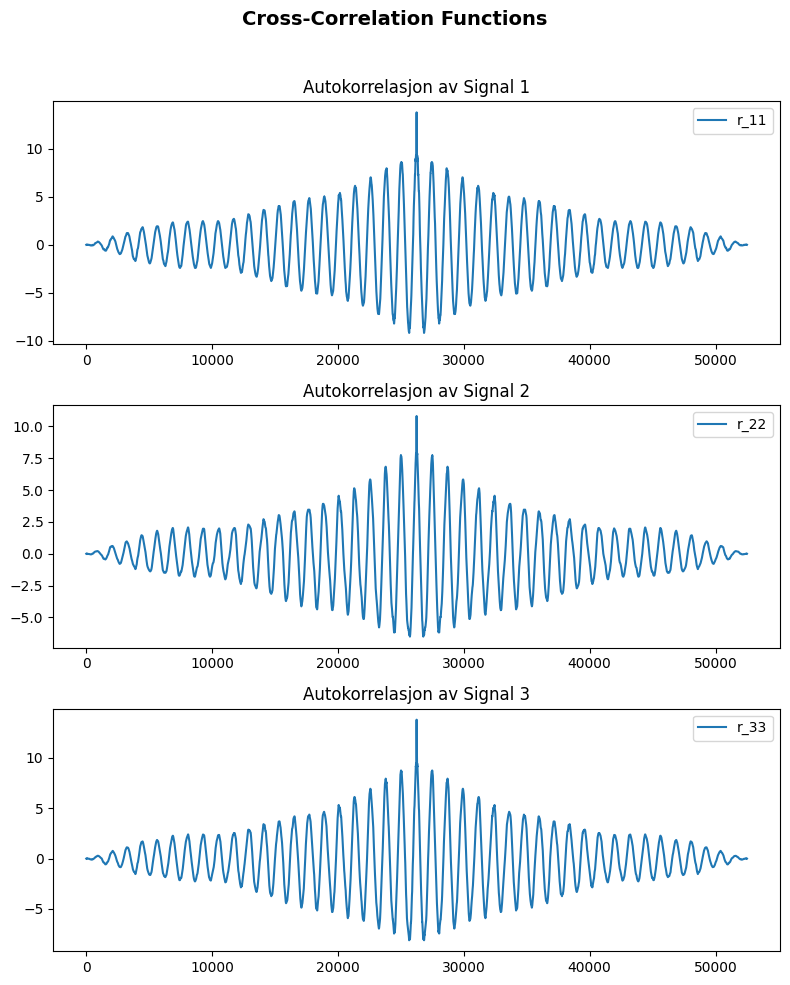

In [110]:
# Create a new figure
plt.figure(figsize=(8, 10))  # Adjust size as needed

# Common title
plt.suptitle("Cross-Correlation Functions", fontsize=14, fontweight='bold')

# First plot
plt.subplot(3, 1, 1)  # (rows, columns, index)
plt.plot(r_11, label="r_11")
plt.title("Autokorrelasjon av Signal 1")
plt.legend()

# Second plot
plt.subplot(3, 1, 2)
plt.plot(r_22, label="r_22")
plt.title("Autokorrelasjon av Signal 2")
plt.legend()

# Third plot
plt.subplot(3, 1, 3)
plt.plot(r_33, label="r_33")
plt.title("Autokorrelasjon av Signal 3")
plt.legend()

# Show all plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()




4) Beregn innfallsvinkelen (i planet som de tre mikrofonene er plassert) fra de tre tidsforsinkelsene. Vis at du kan detektere innfallsvinkel fra −180 til +180 grader

In [117]:
#hente inn data fra måling
#1000Hz_sinus_180G.bin klapp_0G.bin
def theta(n_21, n_31, n_32):
    if ((n_31 - n_21 + 2*n_32) < 0):
        theta = np.arctan2(np.sqrt(3) * (n_31 + n_21), (n_31 - n_21 + 2*n_32 + 1e-10)) + np.pi # legger til + 1e-10 for å ikke dele på 0 i arctan funk
    else:
        theta = np.arctan2(np.sqrt(3) * (n_31 + n_21), (n_31 - n_21 + 2*n_32 + 1e-10))

    theta = theta * (180/np.pi)  
    print(f"Innfallsvinkelen theta er på {theta} grader\n\n\n")
    return theta

mode = "klapp"
for i in [0, 45, 90, 135, 180, "m135", "m90", "m45"]:
    sample_period, data = raspi_import(mode+ "_"+str(i)+"G.bin")

    #juster data
    k= 3.3/4096 #2^12 pga 12-bits ADC bit_signal = Signal/k
    data = data[5000:,:]*k 
    data = data - np.mean(data, axis=0) #fjerner DC-komponenten til signalet

    fs = 1/sample_period

    mic_1 = data[:,0] #ADC1
    mic_2 = data[:,3] #ADC4
    mic_3 = data[:,2] #ADC3

    n_21 = delay_samples(mic_2, mic_1, 2, 1)
    n_31 = delay_samples(mic_3, mic_1, 3, 1)
    n_32 = delay_samples(mic_3, mic_2, 3, 2)

    theta(n_21, n_31, n_32)


Krysskorrelasjonen har en spike ved 26246
Autokorrelasjonen har en spike ved 26249
Delay mellom mikrofon mic 2 og mic 1 i antall samples: -3
Krysskorrelasjonen har en spike ved 26246
Autokorrelasjonen har en spike ved 26249
Delay mellom mikrofon mic 3 og mic 1 i antall samples: -3
Krysskorrelasjonen har en spike ved 26249
Autokorrelasjonen har en spike ved 26249
Delay mellom mikrofon mic 3 og mic 2 i antall samples: 0
Innfallsvinkelen theta er på -89.99999999944868 grader



Krysskorrelasjonen har en spike ved 26249
Autokorrelasjonen har en spike ved 26249
Delay mellom mikrofon mic 2 og mic 1 i antall samples: 0
Krysskorrelasjonen har en spike ved 26249
Autokorrelasjonen har en spike ved 26249
Delay mellom mikrofon mic 3 og mic 1 i antall samples: 0
Krysskorrelasjonen har en spike ved 26253
Autokorrelasjonen har en spike ved 26249
Delay mellom mikrofon mic 3 og mic 2 i antall samples: 4
Innfallsvinkelen theta er på 0.0 grader



Krysskorrelasjonen har en spike ved 26249
Autokorrelasjon

5. Gjør en systematisk variasjon av estimert innfallsvinkel for flere innfallsvinkler. Gjør flere,
minimum 5, gjentatte målinger for samme innfallsvinkel for å få et mål på usikkerheten.
Standardavviket og variansen er mål som godkjennes. Gjør dette for minimum 3 forskjellige
vinkler